# Importing Libraries

In [1]:
!pip install efficientnet -q
!pip install pydrive -q

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import efficientnet.tfkeras as efn

from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import StratifiedKFold


from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth

# Configuration

In [3]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [4]:
COMPETITION_NAME = "siim-covid19-resized-to-512px-png"
strategy = auto_select_accelerator()
BATCH_SIZE = strategy.num_replicas_in_sync * 16
GCS_DS_PATH = KaggleDatasets().get_gcs_path(COMPETITION_NAME)

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [5]:
class Config:
    IMG_SIZE = 512
    NUM_REPLICAS_IN_SYNC = strategy.num_replicas_in_sync
    BATCH_SIZE = 16 * NUM_REPLICAS_IN_SYNC
    GDC_DS_PATH = GCS_DS_PATH
    NUM_CLASSES = 4
    LR = 0.001 * NUM_REPLICAS_IN_SYNC
    EPOCHS = 20

In [6]:
config = Config()

# Loading data

In [7]:
study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
study_df['study_id'] = study_df['id'].map(lambda x: x.split('_')[0])
study_df.drop(columns = 'id', inplace=True)
study_df.head(2)

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_id
0,0,1,0,0,00086460a852
1,0,0,0,1,000c9c05fd14


In [8]:
original_image_paths = glob.glob('../input/siim-covid19-detection/train/*/*/*')

In [9]:
temp_df = pd.DataFrame()
temp_df['image_paths'] = original_image_paths
temp_df['image_id'] = temp_df['image_paths'].map(lambda x: x.split('/')[-1].split('.')[0])
temp_df['study_id'] = temp_df['image_paths'].map(lambda x: x.split('/')[-3])

meta_df = pd.read_csv('../input/siim-covid19-resized-to-512px-png/meta.csv')
meta_df = meta_df[meta_df['split'] == 'train']
meta_df.drop(columns='split', inplace=True)

meta_df = pd.merge(meta_df, temp_df, on='image_id')
meta_df.head(2)

,image_id,dim0,dim1,image_paths,study_id
0,d8ba599611e5,2336,2836,../input/siim-covid19-detection/train/cd5dd5e6...,cd5dd5e6f3f5
1,29b23a11d1e4,3488,4256,../input/siim-covid19-detection/train/49358afc...,49358afcfb80


In [10]:
study_df = pd.merge(study_df, meta_df, on='study_id')
study_df.drop(columns = ['dim0', 'dim1'], inplace=True)
study_df.columns = ['N', 'T', 'I', 'A', 'study_id', 'image_id', 'image_paths']
study_df.head(2)

,N,T,I,A,study_id,image_id,image_paths
0,0,1,0,0,00086460a852,65761e66de9f,../input/siim-covid19-detection/train/00086460...
1,0,0,0,1,000c9c05fd14,51759b5579bc,../input/siim-covid19-detection/train/000c9c05...


In [11]:
np.sum(study_df.isna())

N              0
T              0
I              0
A              0
study_id       0
image_id       0
image_paths    0
dtype: int64

In [12]:
def get_class(mat):
    final = []
    for row in mat:
        res = 0
        for i in row:
            if i==1:
                final.append(res)
            else:
                res += 1
    return final
            
study_df['label'] = get_class(study_df[['N', 'T', 'I', 'A']].values)
study_df.head(2)

,N,T,I,A,study_id,image_id,image_paths,label
0,0,1,0,0,00086460a852,65761e66de9f,../input/siim-covid19-detection/train/00086460...,1
1,0,0,0,1,000c9c05fd14,51759b5579bc,../input/siim-covid19-detection/train/000c9c05...,3


In [13]:
len(study_df)

6334

In [14]:
splitter = StratifiedKFold(random_state=1234)
study_df['kfold'] = -1

for fold, (trn_, val_) in enumerate(splitter.split(study_df.index, study_df['label'])):
    study_df.loc[val_, 'kfold'] = fold

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [15]:
study_df.kfold.value_counts()

0    1267
1    1267
2    1267
3    1267
4    1266
Name: kfold, dtype: int64

# Creating dataset

In [16]:
def build_decoder(with_labels=True, target_size=(256, 256), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=128, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.with_options(ignore_order)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [17]:
GCS_DS_PATH

'gs://kds-058dc294a98b269b36cddd9dc62b407ecfff45d53408897614146080'

In [18]:
def run_fold(fold):
    
    df_train = study_df[study_df['kfold'] != fold]
    df_valid = study_df[study_df['kfold'] == fold]
    
    train_paths = GCS_DS_PATH + '/train/' + df_train['image_id'] + '.png'
    valid_paths = GCS_DS_PATH + '/train/' + df_valid['image_id'] + '.png'

    train_labels = df_train[['N', 'T', 'I', 'A']].values
    valid_labels = df_valid[['N', 'T', 'I', 'A']].values
    
    train_decoder = build_decoder(with_labels=True, target_size=(config.IMG_SIZE, config.IMG_SIZE), ext='png')
    valid_decoder = build_decoder(with_labels=False, target_size=(config.IMG_SIZE, config.IMG_SIZE), ext='.png')
    
    train_dataset = build_dataset(train_paths,
                                  train_labels,
                                  bsize = config.BATCH_SIZE,
                                  decode_fn = train_decoder)
    
    valid_dataset = build_dataset(valid_paths,
                                 valid_labels,
                                 bsize = config.BATCH_SIZE,
                                 decode_fn = train_decoder,
                                 repeat = False, 
                                 shuffle = False, 
                                 augment = False)
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
    
        base_model = efn.EfficientNetB7(input_shape = (config.IMG_SIZE, config.IMG_SIZE, 3),
                                        weights = 'imagenet',
                                        include_top = False)

        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(config.NUM_CLASSES, activation='sigmoid')
        ])

        model.compile(optimizer = tf.keras.optimizers.Adam(),
                      loss = tf.keras.losses.BinaryCrossentropy(),
                      metrics = [tf.keras.metrics.AUC(multi_label=True)],
                      steps_per_execution = 32)
        
        
        
    lr_scheduler   = tf.keras.callbacks.ReduceLROnPlateau(patience=2, min_delta=0.005)
    early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0.005, patience=3)
    

    history = model.fit(x = train_dataset,
                        validation_data = valid_dataset,
                        epochs = config.EPOCHS,
                        steps_per_epoch = len(df_train)//config.BATCH_SIZE,
                        callbacks = [lr_scheduler, early_stopping])
    
    model.save_weights(f'./EFNet_{fold}_weights.h5', overwrite=True)
    
    return history

# Training the model
Cause of less Computational resources we will only run for 2 folds.

In [19]:
global_history = []

for i in range(2):
    print('\n################################## Fold Started ##################################\n')
    history = run_fold(i)
    print('\n################################## Fold Ended ##################################\n')
    global_history.append(history)


################################## Fold Started ##################################

258441216/258434480 [==============================] - 4s 0us/step
Epoch 1/20
39/39 [==============================] - 478s 12s/step - loss: 0.4739 - auc: 0.6419 - val_loss: 0.4275 - val_auc: 0.7336
Epoch 2/20
39/39 [==============================] - 32s 814ms/step - loss: 0.4110 - auc: 0.7303 - val_loss: 0.4914 - val_auc: 0.7330
Epoch 3/20
39/39 [==============================] - 32s 816ms/step - loss: 0.3919 - auc: 0.7574 - val_loss: 0.5303 - val_auc: 0.7374
Epoch 4/20
39/39 [==============================] - 32s 816ms/step - loss: 0.3780 - auc: 0.7869 - val_loss: 0.3883 - val_auc: 0.7996
Epoch 5/20
39/39 [==============================] - 32s 818ms/step - loss: 0.3604 - auc: 0.8092 - val_loss: 0.3878 - val_auc: 0.8034
Epoch 6/20
39/39 [==============================] - 32s 819ms/step - loss: 0.3596 - auc: 0.8091 - val_loss: 0.3742 - val_auc: 0.8122
Epoch 7/20
39/39 [==============================] -

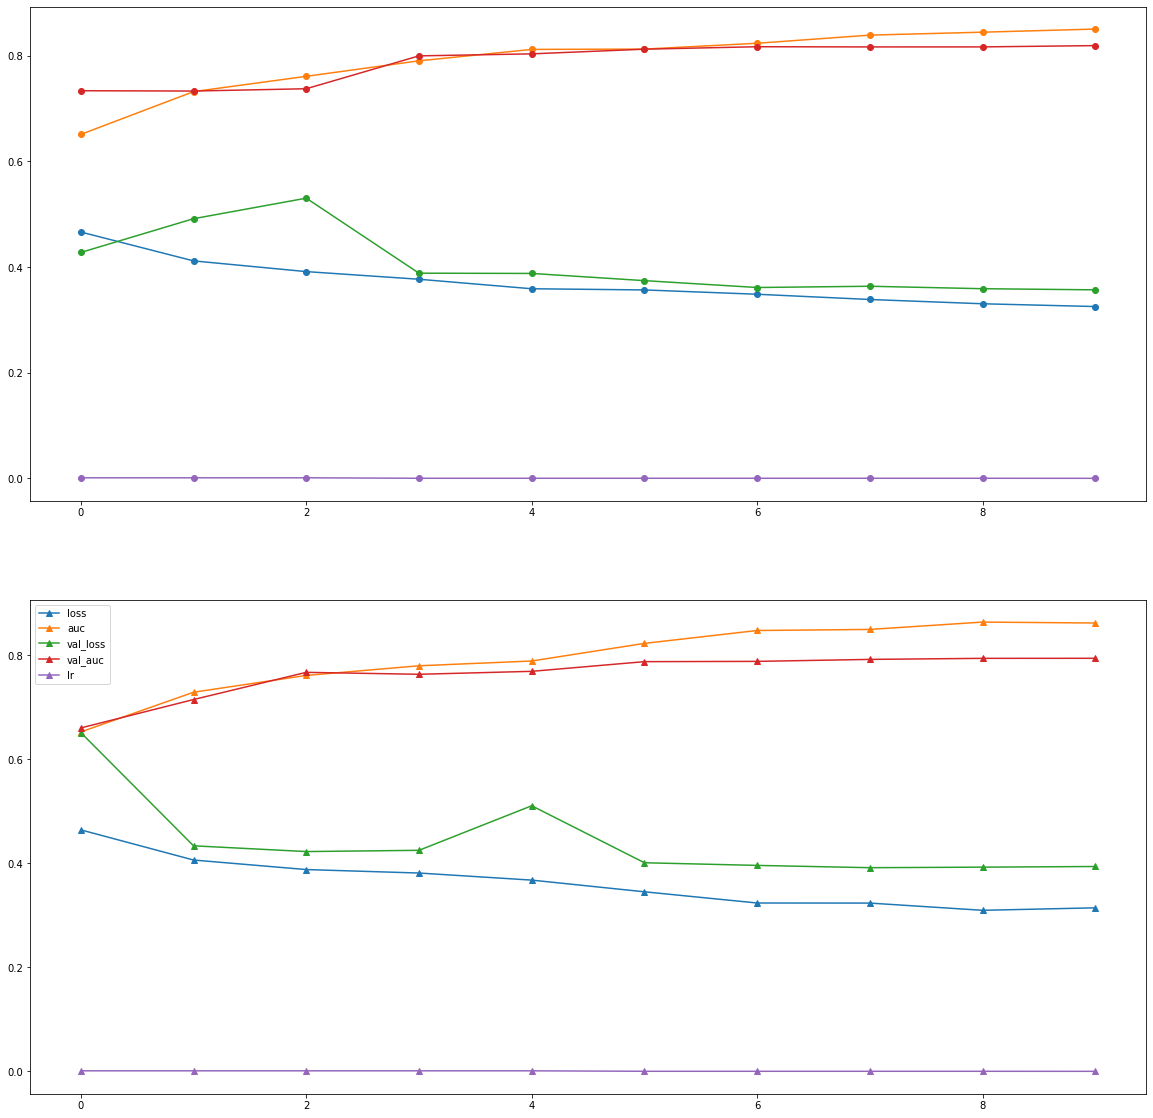

In [38]:
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
for key in global_history[0].history.keys():
    plt.plot(global_history[0].history[key], marker='o', label=key)
plt.subplot(2,1,2)
for key in global_history[1].history.keys():
    plt.plot(global_history[1].history[key], marker='^', label=key)
plt.legend()    